# Responsible Data Science Spring 2022: Homework 1

In [58]:
!git clone https://github.com/lurosenb/superquail
!pip install aif360==0.3.0 
!pip install BlackBoxAuditing
!pip install tensorflow==1.13.1
!pip install folktables

# add
!pip install --upgrade fairlearn==v0.6.0


fatal: destination path 'superquail' already exists and is not an empty directory.


In [59]:
import random
random.seed(6)

import sys
import warnings

import numpy as np
import pandas as pd
import tensorflow as tf
import json
import time 
from tqdm import tqdm

import matplotlib.pyplot as plt 
import seaborn as sns

from folktables import ACSDataSource, ACSEmployment, ACSIncome, ACSPublicCoverage, ACSTravelTime
from superquail.data.acs_helper import ACSData

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler

from aif360.datasets import BinaryLabelDataset, StandardDataset
from aif360.algorithms.preprocessing import DisparateImpactRemover
from aif360.algorithms.inprocessing import PrejudiceRemover
from aif360.algorithms.postprocessing import CalibratedEqOddsPostprocessing, RejectOptionClassification
from aif360.metrics import BinaryLabelDatasetMetric, ClassificationMetric
from aif360.metrics import BinaryLabelDatasetMetric

import BlackBoxAuditing
%matplotlib inline

# Problem 2
### **Load and split data** 

#### Load Folktables dataset and set the protected attribute, drop the other protected attribute race


We have included code to read in the folktables dataset. The Folktables dataset is taken from US Census Data and is built to solve a few simple prediction tasks. The sample we pull is data from 2018 in California. The column names are described in the table below. Note that certain categorical variables have been mapped to integer values, which we will keep as is for the following analyses.

For more information on the this dataset, please see the following paper:
https://eaamo2021.eaamo.org/accepted/acceptednonarchival/EAMO21_paper_16.pdf

| Column Name | Feature | Description/Notes |
| --- | ----------- | --- |
| PINCP | Total person’s income | (Target) 1 if >= $50k, 0 if less |
| SEX | Sex | (Sensitive Attribute) Male=1, Female=2 |
| RAC1P | Race | Dropped from this analysis to focus on one sensitive attribute |
| AGEP | Age | Ranges from 0-99 |
| COW | Class of Worker | Ranges 1-9, see paper for description |
| SCHL | Education Level | Ranges 1-24, see paper for description |
| MAR | Marital Status | Ranges 1-5, see paper for description |
| OCCP | Occupation | Codes taken from Public Use Microdata Sample (PUMS) from the US Census, see paper |
| POBP | Place of Birth | Codes taken from Public Use Microdata Sample (PUMS) from the US Census, see paper |
| RELP | Relationship | Relationship of individual to person who responded to the Census taker. Ranges 0-17, see paper for description |
| WKHP | Hours worked per week | Ranges from 0-99, averaged over previous year |

In [60]:
np.random.seed(13)
protected_attr = 'SEX' #set sex as the protected attribute
target = 'PINCP' #personal income as the target (1=(>50k))

#read in the folktables dataset 
full_df, features_df, target_df, groups_df = ACSData().return_acs_data_scenario(scenario="ACSIncome", subsample=70000)
full_df = full_df.drop(columns='RAC1P') #drop race -- another protected attribute from our dataset

print(full_df.shape)
full_df.head()

(70000, 10)


,AGEP,COW,SCHL,MAR,OCCP,POBP,RELP,WKHP,SEX,PINCP
0,44.0,1.0,1.0,1.0,4220.0,6.0,10.0,40.0,1.0,0.0
1,66.0,2.0,20.0,2.0,4720.0,42.0,0.0,32.0,2.0,0.0
2,72.0,6.0,18.0,1.0,10.0,6.0,1.0,8.0,2.0,1.0
3,53.0,1.0,21.0,1.0,1460.0,457.0,0.0,40.0,1.0,1.0
4,55.0,1.0,16.0,1.0,220.0,6.0,1.0,40.0,1.0,0.0


In [61]:
# convert this dataframe into an aif360 dataset
dataset_orig = BinaryLabelDataset(
    favorable_label=1,
    unfavorable_label=0,
    df=full_df,
    label_names=[target],
    protected_attribute_names=[protected_attr])
privileged_groups = [{protected_attr: 1}] 
unprivileged_groups = [{protected_attr: 2}]

### Create the train test val split

In [62]:
#YOUR CODE HERE
# Split original data into train and test data
train_orig, test_orig = dataset_orig.split([0.8], shuffle=True, seed = 10) # seed = 10 necessary??
# Split training data into train and validation data for hyperparameter tuning(> validation data)
train_orig, val_orig = train_orig.split([0.875], shuffle=True)

# Conver to dataframe
train_orig_df, _ = train_orig.convert_to_dataframe()
val_orig_df, _ = val_orig.convert_to_dataframe()
test_orig_df, _ = test_orig.convert_to_dataframe()

print("Train set: ", train_orig_df.shape)
print("Val set: ", val_orig_df.shape)
print("Test set: ", test_orig_df.shape)

Train set:  (49000, 10)
Val set:  (7000, 10)
Test set:  (14000, 10)


In [63]:
print(train_orig_df.columns)
train_orig_df.head()

Index(['AGEP', 'COW', 'SCHL', 'MAR', 'OCCP', 'POBP', 'RELP', 'WKHP', 'SEX',
       'PINCP'],
      dtype='object')


,AGEP,COW,SCHL,MAR,OCCP,POBP,RELP,WKHP,SEX,PINCP
18884,62.0,1.0,11.0,1.0,3602.0,247.0,1.0,40.0,2.0,1.0
18842,24.0,1.0,16.0,5.0,5610.0,6.0,2.0,40.0,1.0,0.0
16031,45.0,1.0,8.0,1.0,5610.0,303.0,1.0,40.0,1.0,0.0
69028,59.0,1.0,22.0,1.0,1021.0,210.0,1.0,40.0,1.0,1.0
37596,45.0,1.0,22.0,1.0,3030.0,6.0,1.0,40.0,2.0,1.0


# Problem 2, Part (a) 
### **Train a baseline Random Forest (RF) model and report metrics**

### Train a random forest model - Baseline

In [78]:
#YOUR CODE HERE
from sklearn.ensemble import RandomForestClassifier

X_train = train_orig_df.drop(target, axis=1) # personal income as the target (1=(>50k)) is a label to be predicted
y_train = train_orig_df[target]

X_test = test_orig_df.drop(target, axis=1)
y_test = test_orig_df[target]

clf = RandomForestClassifier(n_estimators=100) # check parameters
clf.fit(X_train, y_train)
classified = clf.predict(X_test)

metric_train = BinaryLabelDatasetMetric(
    train_orig,
    unprivileged_groups=unprivileged_groups,
    privileged_groups=privileged_groups
)
# metric_train = ClassificationMetric(
#     train_orig,
#     classified_dataset= classified,
#     unprivileged_groups=unprivileged_groups,
#     privileged_groups=privileged_groups
# )

### Calculate Metrics

In [84]:
#YOUR CODE HERE
from fairlearn.metrics import MetricFrame
from fairlearn.metrics import selection_rate, false_negative_rate, false_positive_rate


# accuracy
accuracy = accuracy_score(y_test, classified)
print("Accuracy = %f" % accuracy) # verifying

metric_fns = {'FPR': false_positive_rate,
              'accuracy': accuracy_score}

grouped_on_sex = MetricFrame(metric_fns,
                              y_test, classified,
                              sensitive_features=X_test['SEX'])


print(grouped_on_sex.by_group['accuracy'])
for row in (grouped_on_sex.by_group['accuracy']):
  print(row)
print(type(grouped_on_sex.by_group['accuracy']))

print("Disparate Impact = %f" % metric_train.disparate_impact())

FPRdiff = grouped_on_sex.by_group['FPR'].diff()[2.0]
print("False positive rate difference: %f " % FPRdiff)

# metric_fns = {'samplesize': samplesize, 
#               'selection_rate': selection_rate,  # i.e., the percentage of the population which have ‘1’ as their label
#               'FNR': false_negative_rate, 
#               'FPR': false_positive_rate, 
#               'accuracy': skm.accuracy_score,
#               'average_precision': skm.average_precision_score,
#               'roc_auc_score': insensitive_roc_auc 
#               }

# grouped_on_race = MetricFrame(metric_fns,
#                              y_test, y_pred,
#                              sensitive_features=A_test['race'])



Accuracy = 0.804857
SEX
1.0    0.798746
2.0    0.811581
Name: accuracy, dtype: object
0.7987455685846742
0.8115811581158116
<class 'pandas.core.series.Series'>
Disparate Impact = 0.761670
False positive rate difference: -0.055104 


# Problem 2, Part (b)
### **Hyperparameter tuning of baseline RF model**

In [86]:
# for boxplots
def plot_init_v_tuned_box(init_metrics, tuned_metrics, metric_name):
  '''Creates a bar graph comparing init_metrics to tuned_metrics'''

  # Make some x values
  x_init = list(range(len(init_metrics)))
  x_tuned = [x + 0.35 for x in x_init]

  # Plot the metrics
  plt.boxplot([init_metrics, tuned_metrics], labels=['Initial Model', 'Tuned Model'])

  # Create labels, etc. 
  plt.ylabel(metric_name)
  plt.legend()
  plt.show()

### Define a program to conduct tune the Random Forest
Optimize the AUC (-> Accuracy). You should try the following hyperparameters: <br>
max_depth=[1, 5, 10] <br>
n_estimators=[1, 5, 10, 15, 20]

In [87]:
#YOUR CODE HERE

max_depth=[1, 5, 10]
n_estimators=[1, 5, 10, 15, 20]

# 10 splits
splitted_X_trains = []
splitted_y_trains = []
splitted_X_vals = []
splitted_y_vals = []
splitted_X_tests = []
splitted_y_tests = []

accuracies = [] # [accuracy, (max_depth, n_estimators)]
SPLITS = 10
for i in range(SPLITS):
  # Split original data into train and test data
  train_sub, test_sub = dataset_orig.split([0.8], shuffle=True, seed = i) # seed = 10 necessary??
  # Split training data into train and validation data for hyperparameter tuning(> validation data)
  train_sub, val_sub = train_sub.split([0.875], shuffle=True, seed = i)
  
  # Conver to dataframe
  train_sub_df, _ = train_sub.convert_to_dataframe()
  val_sub_df, _ = val_sub.convert_to_dataframe()
  test_sub_df, _ = test_sub.convert_to_dataframe()

  for j in range(0, len(max_depth)):
    for k in range(0, len(n_estimators)):
      curMaxDepth, curNestimators = max_depth[j], n_estimators[k]
      X_train = train_sub_df.drop(target, axis=1) # personal income as the target (1=(>50k)) is a label to be predicted
      y_train = train_sub_df[target]
      
      X_val = val_sub_df.drop(target, axis=1)
      y_val = val_sub_df[target]

      X_test = test_sub_df.drop(target, axis=1)
      y_test = test_sub_df[target]

      splitted_X_trains.append(X_train)
      splitted_y_trains.append(y_train)
      splitted_X_vals.append(X_val)
      splitted_y_vals.append(y_val)
      splitted_X_tests.append(X_test)
      splitted_y_tests.append(y_test)
      
      clf = RandomForestClassifier(n_estimators=n_estimators[k], max_depth=max_depth[j]) # check parameters
      clf.fit(X_train, y_train)
      classified = clf.predict(X_val)
      
      metric_train = BinaryLabelDatasetMetric(
          train_orig,
          unprivileged_groups=unprivileged_groups,
          privileged_groups=privileged_groups
          )
      
      accuracy = accuracy_score(y_val, classified)
      accuracies.append([accuracy, (max_depth[j], n_estimators[k])])
      #print("Accuracy = %f" % accuracy)

accuracies.sort(reverse=True)
print(accuracies)
      
      # metric_fns = {'FPR': false_positive_rate,
      #               'accuracy': accuracy_score}
      
      # grouped_on_race = MetricFrame(metric_fns,
      #                               y_test, classified,
      #                               sensitive_features=X_test['SEX'])
      # print(grouped_on_race.by_group['accuracy'])
      # print("Disparate Impact = %f" % metric_train.disparate_impact())
      
      # FPRdiff = grouped_on_race.by_group['FPR'].diff()[2.0]
      # print("False positive rate difference: %f " % FPRdiff)



  # print("Train set: ", train_sub_df.head())
  # print("Val set: ", val_sub_df.head())
  # print("Test set: ", test_sub_df.head())

# from fairlearn.reductions import GridSearch
# from fairlearn.reductions import ErrorRate

# max_depth=[1, 5, 10]
# n_estimators=[1, 5, 10, 15, 20]

# attrs = {'max_depth': max_depth, 'n_estimators':n_estimators}

# # RandomizedSearchCV ??

# sweep = GridSearch(RandomForestClassifier(attrs),
#                    constraints=ErrorRate(),
#                    constraint_weight=0.1,
#                    grid_size=5)

# sweep.fit(X_train, y_train,
#           sensitive_features=X_train['SEX'])



[[0.8172857142857143, (10, 15)], [0.815, (10, 10)], [0.8147142857142857, (10, 10)], [0.8142857142857143, (10, 15)], [0.8135714285714286, (10, 20)], [0.8134285714285714, (10, 10)], [0.8132857142857143, (10, 20)], [0.812, (10, 20)], [0.8115714285714286, (10, 20)], [0.8108571428571428, (10, 5)], [0.8108571428571428, (10, 5)], [0.8105714285714286, (10, 15)], [0.8101428571428572, (10, 5)], [0.8098571428571428, (10, 15)], [0.8097142857142857, (10, 10)], [0.8095714285714286, (10, 15)], [0.8094285714285714, (10, 20)], [0.8084285714285714, (10, 5)], [0.8074285714285714, (10, 20)], [0.8067142857142857, (10, 10)], [0.8052857142857143, (10, 20)], [0.8051428571428572, (10, 15)], [0.8047142857142857, (10, 10)], [0.8045714285714286, (10, 20)], [0.8044285714285714, (10, 15)], [0.8044285714285714, (10, 5)], [0.8038571428571428, (10, 20)], [0.8028571428571428, (10, 15)], [0.8027142857142857, (10, 10)], [0.8024285714285714, (10, 10)], [0.8018571428571428, (10, 5)], [0.8014285714285714, (10, 15)], [0.8014

### Compare the initial model to the fine-tuned model for 10 train/val/test splits for Random Forest

In [92]:
#YOUR CODE HERE

init_accuracies = []
tuned_accuracies = []

init_disparate_impacts = []
tuned_disparate_impacts = []


for i in range(SPLITS):
  X_train, y_train = splitted_X_trains[i], splitted_y_trains[i]
  X_test, y_test = splitted_X_tests[i], splitted_y_tests[i]

  # initial model
  initial_clf = RandomForestClassifier()
  initial_clf.fit(X_train, y_train)
  initial_classified = initial_clf.predict(X_test)

  metric_fns = {'FPR': false_positive_rate,
                'accuracy': accuracy_score}
  
  grouped_on_sex = MetricFrame(metric_fns,
                               y_test, initial_classified,
                               sensitive_features=X_test['SEX'])
  
  print('Accuracy: ', grouped_on_sex.by_group['accuracy'])
  print("Disparate Impact = %f" % metric_train.disparate_impact()) # TODO: metric_train 같아도 되는지

  FPRdiff = grouped_on_sex.by_group['FPR'].diff()[2.0]
  print("False positive rate difference: %f" % FPRdiff)

  init_accuracies.append(grouped_on_sex.by_group['accuracy'])
  init_disparate_impacts.append(metric_train.disparate_impact())

  
  # fine-tuned model
  tuned_clf = RandomForestClassifier(max_depth=10, n_estimators=15)
  tuned_clf.fit(X_train, y_train)
  tuned_classified = tuned_clf.predict(X_test)

  grouped_on_sex = MetricFrame(metric_fns,
                               y_test, tuned_classified,
                               sensitive_features=X_test['SEX'])
  
  print('Accuracy: ', grouped_on_sex.by_group['accuracy'])
  print("Disparate Impact = %f" % metric_train.disparate_impact()) # TODO: metric_train 같아도 되는지

  FPRdiff = grouped_on_sex.by_group['FPR'].diff()[2.0]
  print("False positive rate difference: %f" % FPRdiff)

  tuned_accuracies.append(grouped_on_sex.by_group['accuracy'])
  tuned_disparate_impacts.append(metric_train.disparate_impact())




Accuracy:  SEX
1.0     0.79444
2.0    0.812033
Name: accuracy, dtype: object
Disparate Impact = 0.761670
False positive rate difference: -0.061958
Accuracy:  SEX
1.0    0.797453
2.0    0.811735
Name: accuracy, dtype: object
Disparate Impact = 0.761670
False positive rate difference: -0.069665
Accuracy:  SEX
1.0    0.795672
2.0    0.810391
Name: accuracy, dtype: object
Disparate Impact = 0.761670
False positive rate difference: -0.061397
Accuracy:  SEX
1.0    0.801287
2.0    0.813377
Name: accuracy, dtype: object
Disparate Impact = 0.761670
False positive rate difference: -0.069933
Accuracy:  SEX
1.0    0.794988
2.0    0.811586
Name: accuracy, dtype: object
Disparate Impact = 0.761670
False positive rate difference: -0.061112
Accuracy:  SEX
1.0    0.799233
2.0      0.8086
Name: accuracy, dtype: object
Disparate Impact = 0.761670
False positive rate difference: -0.063411
Accuracy:  SEX
1.0    0.794714
2.0    0.812033
Name: accuracy, dtype: object
Disparate Impact = 0.761670
False positiv

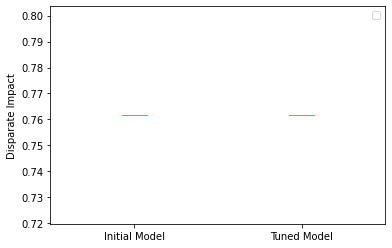

In [93]:
#plot_init_v_tuned_box(init_accuracies, tuned_accuracies, "Accuracy")
#tuned_accuracies
plot_init_v_tuned_box(init_disparate_impacts, tuned_disparate_impacts, "Disparate Impact")

# Problem 2, Part (c) 
### **Disparate Impact Pre-Processing intervention**

In [56]:
def plot_repair_levels(repair_levels, metric_vals, metric_name, x_label='Repair level'):
  '''Creates a line plot showing how the metric changed for different values of repair level'''

  # Plot the metrics
  plt.plot(repair_levels, metric_vals, color='#0384fc', linewidth=3, label=metric_name)

  # Create labels, etc. 
  plt.xlabel(x_label)
  plt.ylabel(metric_name)
  plt.legend()
  plt.show()

In [54]:
di = DisparateImpactRemover(repair_level = 0.3)
dataset_transf_train = di.fit_transform(dataset_orig)
transformed = dataset_transf_train.convert_to_dataframe()[0]
transformed.head()
#dataset_orig.convert_to_dataframe()

,AGEP,COW,SCHL,MAR,OCCP,POBP,RELP,WKHP,SEX,PINCP
0,44.0,1.0,1.0,1.0,4120.0,6.0,10.0,39.0,1.0,0.0
1,66.0,2.0,20.0,2.0,4720.0,42.0,0.0,32.0,2.0,0.0
2,72.0,6.0,18.0,1.0,10.0,6.0,1.0,8.0,2.0,1.0
3,53.0,1.0,21.0,1.0,1440.0,457.0,0.0,39.0,1.0,1.0
4,55.0,1.0,16.0,1.0,205.0,6.0,1.0,39.0,1.0,0.0


### Apply pre-processing techniques to the dataset, then re-train the models with the optimal hyperparameters from part **b**

SEX
1.0    0.805355
2.0    0.816047
Name: accuracy, dtype: object
SEX
1.0    0.806987
2.0    0.817251
Name: accuracy, dtype: object
SEX
1.0    0.807938
2.0    0.813939
Name: accuracy, dtype: object
SEX
1.0    0.807122
2.0    0.811681
Name: accuracy, dtype: object
SEX
1.0    0.802637
2.0    0.816649
Name: accuracy, dtype: object


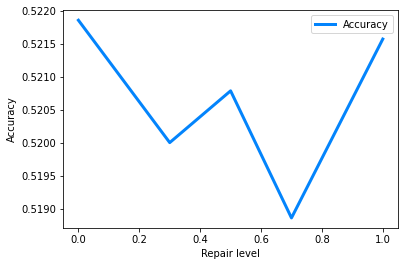

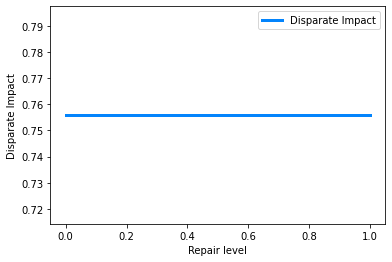

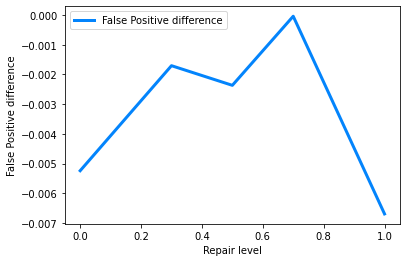

In [57]:
#YOUR CODE HERE
from sklearn.model_selection import train_test_split

# 5 metrics
accuracies = []
accuracies_privileged = []
accuracies_unprivileged = []
disparate_impacts = []
FPRdiffenrences = []

def test_disparate_impact_remover(repair_level):
  # preprocessing
  di = DisparateImpactRemover(repair_level = repair_level)
  dataset_transf_train = di.fit_transform(dataset_orig)
  transformed = dataset_transf_train.convert_to_dataframe()[0]
  transformed.head()

  #print(transformed['SEX'])
  
  X_trans = transformed.drop([target], axis = 1)
  y_trans = transformed[target]
  
  # TODO check split to validation set?
  X_trans_train, X_trans_test, y_trans_train, y_trans_test = train_test_split(X_trans, y_trans, test_size=0.2, random_state=0)
  
  clf = RandomForestClassifier()
  clf.fit(X_trans_train, y_trans_train)
  y_predict = clf.predict(X_trans_test)
  
  # metrics
  accuracy = accuracy_score(y_test, y_predict)
  #print("Accuracy = %f" % accuracy)
  accuracies.append(accuracy)
  
  metric_fns = {'FPR': false_positive_rate,
                'accuracy': accuracy_score}
                
  grouped_on_sex = MetricFrame(metric_fns,
                               y_trans_test, y_predict,
                               sensitive_features = X_test['SEX'])
  
  print(grouped_on_sex.by_group['accuracy'])
  
  # convert this dataframe into an aif360 dataset
  transformed_aif = BinaryLabelDataset(
      favorable_label=1,
      unfavorable_label=0,
      df=full_df,
      label_names=[target],
      protected_attribute_names=[protected_attr]
      )
  privileged_groups = [{protected_attr:1}]
  unprivileged_groups = [{protected_attr:2}]


  # TODO check metric trans..??
  metric_trans = BinaryLabelDatasetMetric(
      transformed_aif,
      unprivileged_groups=unprivileged_groups,
      privileged_groups=privileged_groups
      )
  #print("Disparate Impact = %f " % metric_trans.disparate_impact())
  disparate_impacts.append(metric_trans.disparate_impact())
  
  FPRdiff = grouped_on_sex.by_group['FPR'].diff()[2.0]
  FPRdiffenrences.append(FPRdiff)
  #print("False positive rate difference: %f " % FPRdiff)













for rl in [0.0, 0.3, 0.5, 0.7, 1.]:
  test_disparate_impact_remover(rl)

plot_repair_levels([0.0, 0.3, 0.5, 0.7, 1.], accuracies, 'Accuracy')
plot_repair_levels([0.0, 0.3, 0.5, 0.7, 1.], disparate_impacts, 'Disparate Impact')
plot_repair_levels([0.0, 0.3, 0.5, 0.7, 1.], FPRdiffenrences, 'False Positive difference')

# Problem 2, Part (d) 
### **Prejudice Remover In-Processing intervention**



### Fit new models using the Prejudice Remover technique

In [16]:
from aif360.algorithms import preprocessing
#YOUR CODE HERE

# Split original data into train and test data
train_orig, test_orig = dataset_orig.split([0.8], shuffle=True, seed = 10) # seed = 10 necessary??
# Split training data into train and validation data for hyperparameter tuning(> validation data)
train_orig, val_orig = train_orig.split([0.875], shuffle=True)

etas = [0.01, 0.1, 1]

pr = PrejudiceRemover(eta=0.01)

# X_train = train_orig_df.drop(target, axis=1) # personal income as the target (1=(>50k)) is a label to be predicted
# y_train = train_orig_df[target]

# X_test = test_orig_df.drop(target, axis=1)
# y_test = test_orig_df[target]

# train_orig.features = preprocessing.fit_transform(train_orig.features)
# test_orig.features = preprocessing.transform(test_orig.features)
pr.fit(train_orig)
y_pred = pr.predict(test_orig)
# dt_transformed_pr = pr.fit(train_orig)
# transformed_df = dt_transformed_pr.convert_to_dataframe()[0]
# transformed_df.head()

# grouped_on_sex = MetricFrame({'accuracy': accuracy},
#                              test_)


# metrics
#   accuracy = accuracy_score(y_test, y_predict)
#   #print("Accuracy = %f" % accuracy)
#   accuracies.append(accuracy)
  
#   metric_fns = {'FPR': false_positive_rate,
#                 'accuracy': accuracy_score}
                
#   grouped_on_sex = MetricFrame(metric_fns,
#                                y_trans_test, y_predict,
#                                sensitive_features = X_test['SEX'])
  
#   print(grouped_on_sex.by_group['accuracy'])
  
#   # convert this dataframe into an aif360 dataset
#   transformed_aif = BinaryLabelDataset(
#       favorable_label=1,
#       unfavorable_label=0,
#       df=full_df,
#       label_names=[target],
#       protected_attribute_names=[protected_attr]
#       )
#   privileged_groups = [{protected_attr:1}]
#   unprivileged_groups = [{protected_attr:2}]


#   # TODO check metric trans..??
#   metric_trans = BinaryLabelDatasetMetric(
#       transformed_aif,
#       unprivileged_groups=unprivileged_groups,
#       privileged_groups=privileged_groups
#       )
#   #print("Disparate Impact = %f " % metric_trans.disparate_impact())
#   disparate_impacts.append(metric_trans.disparate_impact())




# from aif360.algorithms.inprocessing import PrejudiceRemover
# pr = PrejudiceRemover(eta=100.0)
# dt_train.features = preprocessing.fit_transform(dt_train.features)
# dt_test.features = preprocessing.transform(dt_test.features)
# pr.fit(dt_train);
# y_pred = pr.predict(dt_test).scores >= 0.5



# di = DisparateImpactRemover(repair_level = repair_level)
#   dataset_transf_train = di.fit_transform(dataset_orig)
#   transformed = dataset_transf_train.convert_to_dataframe()[0]
#   transformed.head()

#   #print(transformed['SEX'])
  
#   X_trans = transformed.drop([target], axis = 1)
#   y_trans = transformed[target]
  
#   # TODO check split to validation set?
#   X_trans_train, X_trans_test, y_trans_train, y_trans_test = train_test_split(X_trans, y_trans, test_size=0.2, random_state=0)
  
#   clf = RandomForestClassifier()
#   clf.fit(X_trans_train, y_trans_train)
#   y_predict = clf.predict(X_trans_test)
  
#   # metrics
#   accuracy = accuracy_score(y_test, y_predict)
#   #print("Accuracy = %f" % accuracy)
#   accuracies.append(accuracy)
  
#   metric_fns = {'FPR': false_positive_rate,
#                 'accuracy': accuracy_score}
                
#   grouped_on_sex = MetricFrame(metric_fns,
#                                y_trans_test, y_predict,
#                                sensitive_features = X_test['SEX'])
  
#   print(grouped_on_sex.by_group['accuracy'])
  
#   # convert this dataframe into an aif360 dataset
#   transformed_aif = BinaryLabelDataset(
#       favorable_label=1,
#       unfavorable_label=0,
#       df=full_df,
#       label_names=[target],
#       protected_attribute_names=[protected_attr]
#       )
#   privileged_groups = [{protected_attr:1}]
#   unprivileged_groups = [{protected_attr:2}]


#   # TODO check metric trans..??
#   metric_trans = BinaryLabelDatasetMetric(
#       transformed_aif,
#       unprivileged_groups=unprivileged_groups,
#       privileged_groups=privileged_groups
#       )
#   #print("Disparate Impact = %f " % metric_trans.disparate_impact())
#   disparate_impacts.append(metric_trans.disparate_impact())
  
#   FPRdiff = grouped_on_sex.by_group['FPR'].diff()[2.0]
#   FPRdiffenrences.append(FPRdiff)
#   #print("False positive rate difference: %f " % FPRdiff)

In [18]:
dt_transformed_pr

# Problem 2, Part (e) 
### **Reject Option Post-Processing intervention**

### Using the same random forest models as before, apply the post-processing technique to your results and compare

In [24]:
#YOUR CODE HERE
import aif360.algorithms.postprocessing

roc = RejectOptionClassification(
    unprivileged_groups=unprivileged_groups,
    privileged_groups=privileged_groups
)
roc.classification_threshold = 0.5
roc.ROC_margin = 0.15




# from aif360.algorithms.postprocessing import (
#     RejectOptionClassification
# )
# ROC = RejectOptionClassification(**privileged_groups_params)
# ROC.classification_threshold = 0.5
# ROC.ROC_margin = 0.15
# dt_test.scores = y_prob.reshape(-1, 1)
# y_pred = ROC.predict(dt_test).labels